 
**ЗАДАЧА ПРОЕКТА - проанализировать развлекательное приложение Procrastinate Pro+ и найти причину убытков:**   
- исследовать пользователей из разных стран, их прибыльность, устройства входа;
- изучить рекламные источники и расходы на неё, оценить стоимость привлечения пользователя и окупаемость;
- выявить проблемы привлечения пользователей и предложить решение.

### Загрузим данные и подготовим их к анализу

Выгрузим датасеты и ознакомимся с информацией

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [2]:
try:
    visits = pd.read_csv('/datasets/visits_info_short.csv')
    orders = pd.read_csv('/datasets/orders_info_short.csv')
    costs = pd.read_csv('/datasets/costs_info_short.csv')
except:
    visits = pd.read_csv('https://code.s3.yandex.net/datasets/visits_info_short.csv')
    orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders_info_short.csv')
    costs = pd.read_csv('https://code.s3.yandex.net/datasets/costs_info_short.csv')
    
display(visits.head())
display(orders.head())
display(costs.head())

User Id         Region   Device  Channel        Session Start  \
0  981449118918  United States   iPhone  organic  2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic  2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic  2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop  2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic  2019-05-01 03:33:35   

           Session End  
0  2019-05-01 02:45:01  
1  2019-05-01 04:47:35  
2  2019-05-01 15:32:08  
3  2019-05-01 00:54:25  
4  2019-05-01 03:57:40

User Id             Event Dt  Revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99
3  319939546352  2019-05-01 15:34:40     4.99
4  366000285810  2019-05-01 13:59:51     4.99

dt   Channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.4
4  2019-05-05  FaceBoom  122.1

Уберём верхний регистр и пропуски в названиях столбцов

In [3]:
visits.columns = visits.columns.str.lower()
visits = visits.rename(columns={'user id' : 'user_id', 'session start' : 'session_start', 'session end' : 'session_end'})

In [4]:
orders.columns = orders.columns.str.lower()
orders = orders.rename(columns={'user id' : 'user_id', 'event dt' : 'event_dt'})

In [5]:
costs.columns = costs.columns.str.lower()

Проверим данные на пропуски

In [6]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        309901 non-null  int64 
 1   region         309901 non-null  object
 2   device         309901 non-null  object
 3   channel        309901 non-null  object
 4   session_start  309901 non-null  object
 5   session_end    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   40212 non-null  int64  
 1   event_dt  40212 non-null  object 
 2   revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [8]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


Пропущенных значений нет.

Проверим данные на явные дубликаты

In [9]:
visits.duplicated().sum()

0

In [10]:
orders.duplicated().sum()

0

In [11]:
costs.duplicated().sum()

0

Явных дубликатов нет.

Переведем дату и время в нужный формат

In [12]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

In [13]:
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

In [14]:
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

Проверим соответствие данных названиям столбцов, а также посмотрим соотношение.

<Axes: >

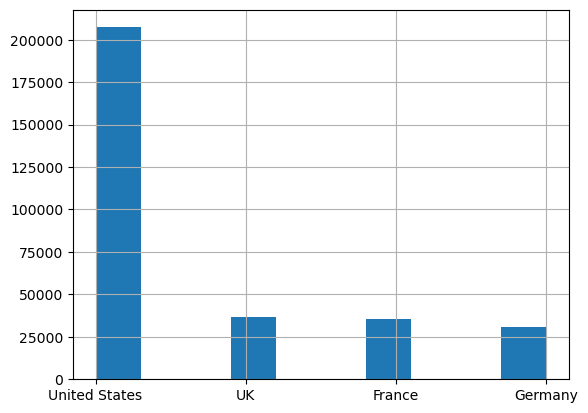

In [15]:
visits['region'].hist()

Пользователей из US значительно больше, чем из других стран.

<Axes: >

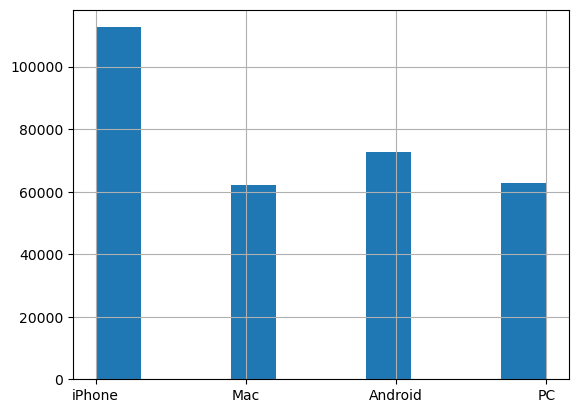

In [16]:
visits['device'].hist()

Наибольшее количество клиентов пользуются приложением с помощью iPhone.

<Axes: >

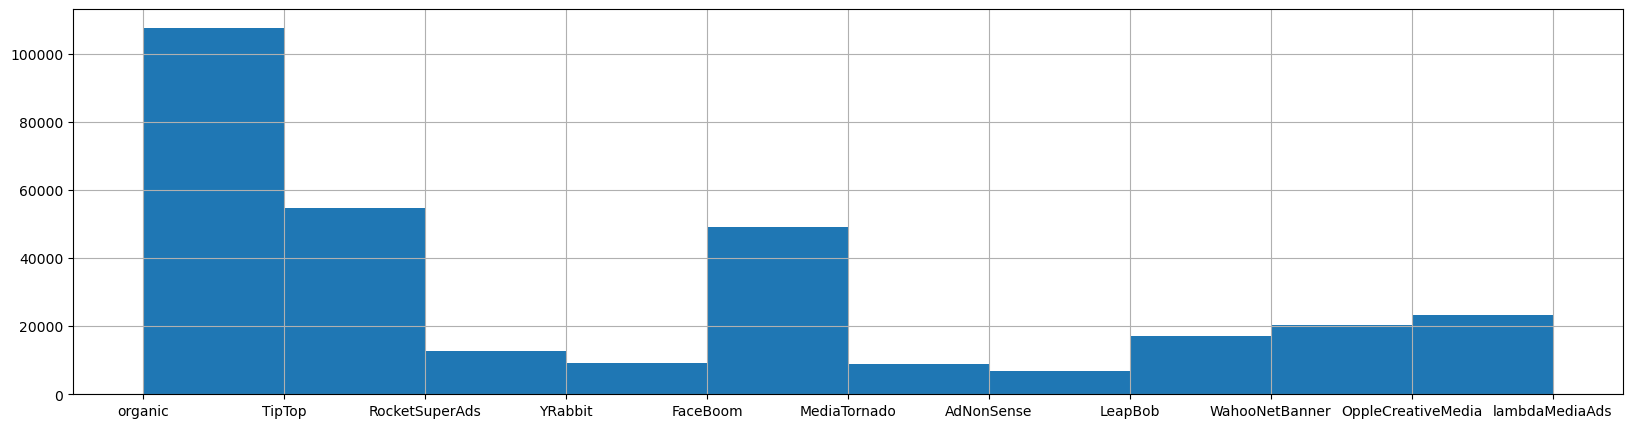

In [17]:
visits['channel'].hist(figsize=(20, 5))

Больше всего пользователей привлечено через каналы Organic, Tiptop и FacceBoom. 

<Axes: >

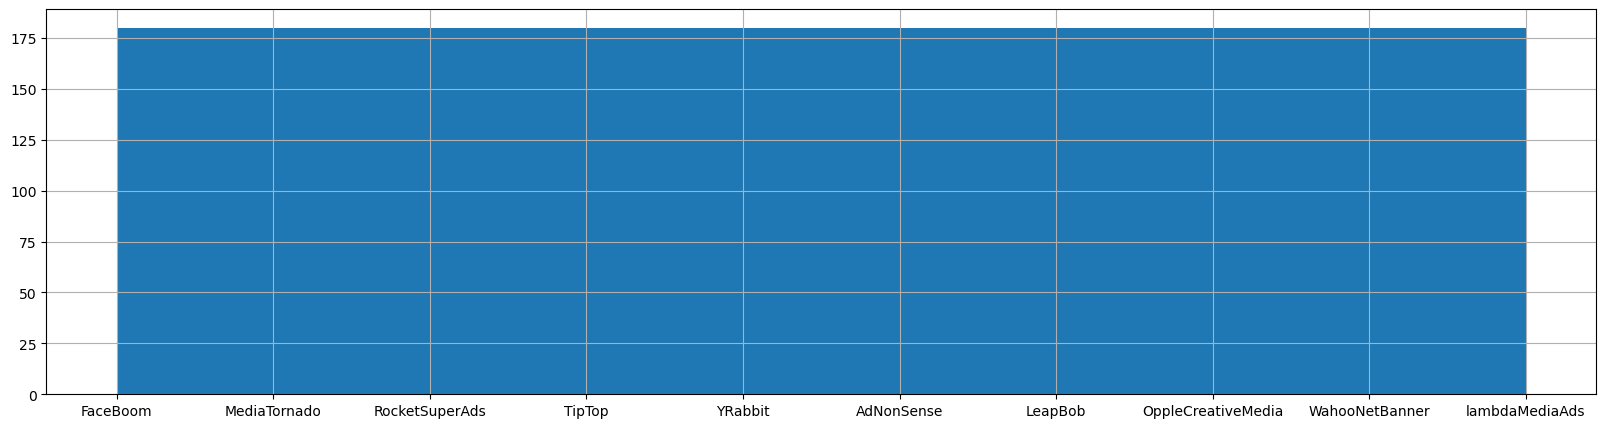

In [18]:
costs['channel'].hist(figsize=(20, 5))

In [19]:
costs.groupby('channel')['costs'].sum().sort_values(ascending=False)

channel
TipTop                54751.30
FaceBoom              32445.60
WahooNetBanner         5151.00
AdNonSense             3911.25
OppleCreativeMedia     2151.25
RocketSuperAds         1833.00
LeapBob                1797.60
lambdaMediaAds         1557.60
MediaTornado            954.48
YRabbit                 944.22
Name: costs, dtype: float64

Было проведено одинаковое количество рекламных компаний. Значительно больше средств было выделено на каналы TipTop и FaceBoom.

### Расчёт и анализ LTV, ROI, удержания и конверсии.

Разрешается использовать функции, с которыми вы познакомились в теоретических уроках.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

Зададим функции для расчета нужных метрик:

In [20]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles


In [21]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [22]:

# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [23]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

Зададим функции для построения графиков:

In [24]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [25]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [26]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [27]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Исследовательский анализ данных

#### Создадим профили пользователей:

In [28]:
profiles = get_profiles(visits, orders, costs)
display(profiles)

user_id            first_ts       channel  device         region  \
0             599326 2019-05-07 20:58:57      FaceBoom     Mac  United States   
1            4919697 2019-07-09 12:46:07      FaceBoom  iPhone  United States   
2            6085896 2019-10-01 09:58:33       organic  iPhone         France   
3           22593348 2019-08-22 21:35:48    AdNonSense      PC        Germany   
4           31989216 2019-10-02 00:07:44       YRabbit  iPhone  United States   
...              ...                 ...           ...     ...            ...   
150003  999956196527 2019-09-28 08:33:02        TipTop  iPhone  United States   
150004  999975439887 2019-10-21 00:35:17       organic      PC             UK   
150005  999976332130 2019-07-23 02:57:06        TipTop  iPhone  United States   
150006  999979924135 2019-09-28 21:28:09  MediaTornado      PC  United States   
150007  999999563947 2019-10-18 19:57:25       organic  iPhone  United States   

                dt               month  payer  acquisition_cost  
0       2019-05-07 2019-05-07 20:58:57   True          1.088172  
1       2019-07-09 2019-07-09 12:46:07  False          1.107237  
2       2019-10-01 2019-10-01 09:58:33  False          0.000000  
3       2019-08-22 2019-08-22 21:35:48  False          0.988235  
4       2019-10-02 2019-10-02 00:07:44  False          0.230769  
...            ...                 ...    ...               ...  
150003  2019-09-28 2019-09-28 08:33:02  False          3.500000  
150004  2019-10-21 2019-10-21 00:35:17  False          0.000000  
150005  2019-07-23 2019-07-23 02:57:06  False          2.600000  
150006  2019-09-28 2019-09-28 21:28:09  False          0.205714  
150007  2019-10-18 2019-10-18 19:57:25  False          0.000000  

[150008 rows x 9 columns]

Определите минимальную и максимальную даты привлечения пользователей:

In [29]:
min_date = profiles['dt'].min()
max_date = profiles['dt'].max()
print('Минимальная дата привлечения пользователей:', min_date)
print('Максимальная дата привлечения пользователей:', max_date)

Минимальная дата привлечения пользователей: 2019-05-01
Максимальная дата привлечения пользователей: 2019-10-27


Минимальная и максимальная даты привлечения пользователей абсолютно совпадают с техническим заданием проекта.

Рассматриваемый диапазон данных - 6 месяцев.

#### Соотношение платящих пользователей по странам и их доля

Для общего представления посчитаем конверсию в покупку: 

In [30]:
print('Из всех пользователей, зашедших в приложение Procrastinate Pro+ в исследуемый период,', 
      round(orders['user_id'].nunique() / profiles['user_id'].count() * 100), '% совершили покупку.')

Из всех пользователей, зашедших в приложение Procrastinate Pro+ в исследуемый период, 6 % совершили покупку.


In [31]:
region_share = (profiles.query('payer == True')
    .pivot_table(index='region', values='user_id', aggfunc=['count']))
region_share.columns = ['users']
region_share['share_%'] = round(region_share['users'] / region_share['users'].sum() * 100)
region_share.sort_values(by='users', ascending=False)

users  share_%
region                       
United States   6902     78.0
UK               700      8.0
France           663      7.0
Germany          616      7.0

Соотношение платящих пользователей по странам:
- Основная доля пользователей из США
- Доля пользователей из Великобритании, Франции и Германии почти одинаковая

#### Устройства, которыми пользуются платящие клиенты

Построим таблицу платящих пользователей, совершивших хотя бы одну покупку, и найдем долю платящих по каждому девайсу.

In [32]:
devices = (profiles.query('payer == True')
    .pivot_table(index='device', values='user_id', aggfunc='count'))
devices.columns = ['amount']
devices['share_%'] = round(devices['amount'] /  devices['amount'].sum() * 100)
devices.sort_values(by='amount', ascending=False)

amount  share_%
device                  
iPhone     3382     38.0
Android    2050     23.0
Mac        1912     22.0
PC         1537     17.0

Пользователи заходят в приложение с четырёх устройств: **iPhone, Mac, Android и PC:** 
- Больше всего платящих пользователей с устройств **iPhone**  
- Меньше всего пользователей с **PC**.

#### Рекламные источники привлечения пользователей 

In [33]:
channels = (profiles.query('payer == True')
    .pivot_table(index='channel', values='user_id', aggfunc='count'))
channels.columns = ['amount']
channels['share_%'] = round(channels['amount'] /  channels['amount'].sum() * 100)
channels.sort_values(by='amount', ascending=False)

amount  share_%
channel                            
FaceBoom              3557     40.0
TipTop                1878     21.0
organic               1160     13.0
WahooNetBanner         453      5.0
AdNonSense             440      5.0
RocketSuperAds         352      4.0
LeapBob                262      3.0
OppleCreativeMedia     233      3.0
lambdaMediaAds         225      3.0
YRabbit                165      2.0
MediaTornado           156      2.0

Больше всего платящих пользователей пришло из каналов **FaceBoom, TipTop и Organic**.

### Маркетинг

#### Сумма расходов на маркетинг

In [34]:
total_costs = round(costs['costs'].sum())
print('Общая сумма расходов на маркетинг =', total_costs)

Общая сумма расходов на маркетинг = 105497


#### Распределение трат по рекламным источникам

In [35]:
costs.pivot_table(index='channel', values='costs', aggfunc='sum').sort_values(by='costs', ascending=False)

costs
channel                     
TipTop              54751.30
FaceBoom            32445.60
WahooNetBanner       5151.00
AdNonSense           3911.25
OppleCreativeMedia   2151.25
RocketSuperAds       1833.00
LeapBob              1797.60
lambdaMediaAds       1557.60
MediaTornado          954.48
YRabbit               944.22

Существенно больше денег потратили на рекламу в **TipTop** и **FaceBoom**. При этом с **TipTop** пришло в два раза меньше пользователей.

#### Визуализация динамики изменения расходов во времени

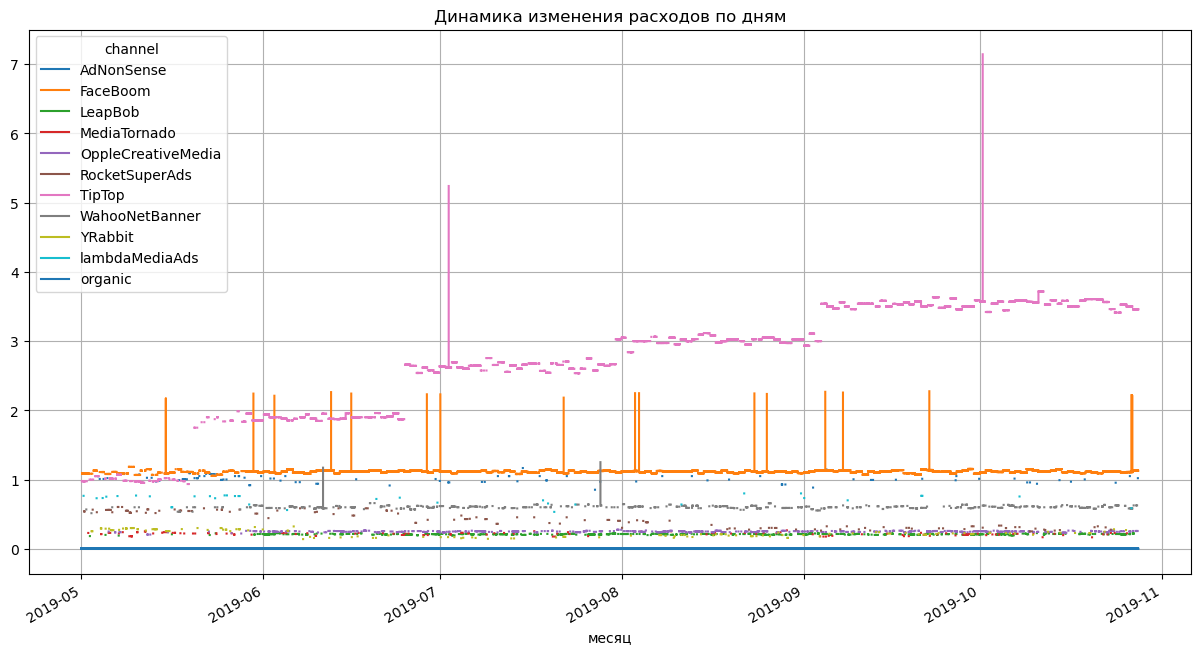

In [36]:
profiles.pivot_table(
    index='month', 
    columns='channel',  
    values='acquisition_cost',  
    aggfunc='sum'  
).plot(figsize=(15, 8), grid=True)
plt.title('Динамика изменения расходов по дням')
plt.xlabel('месяц')
plt.show()

Расходы на рекламу в **TipTop** и **FaceBoom** самые большие. У канала **TipTop** видим каждый месяц повышение стоимости рекламы и две дорогих оплаты за весь промежуток. У **FaceBoom** видим от 2 до 4 раз в месяц пиковые расходы - видимо, это регулярная оплата рекламы. По остальным каналам нет тенденции к повышению или пиковых оплат.

In [37]:
profiles['week'] = profiles['first_ts'].dt.isocalendar().week 

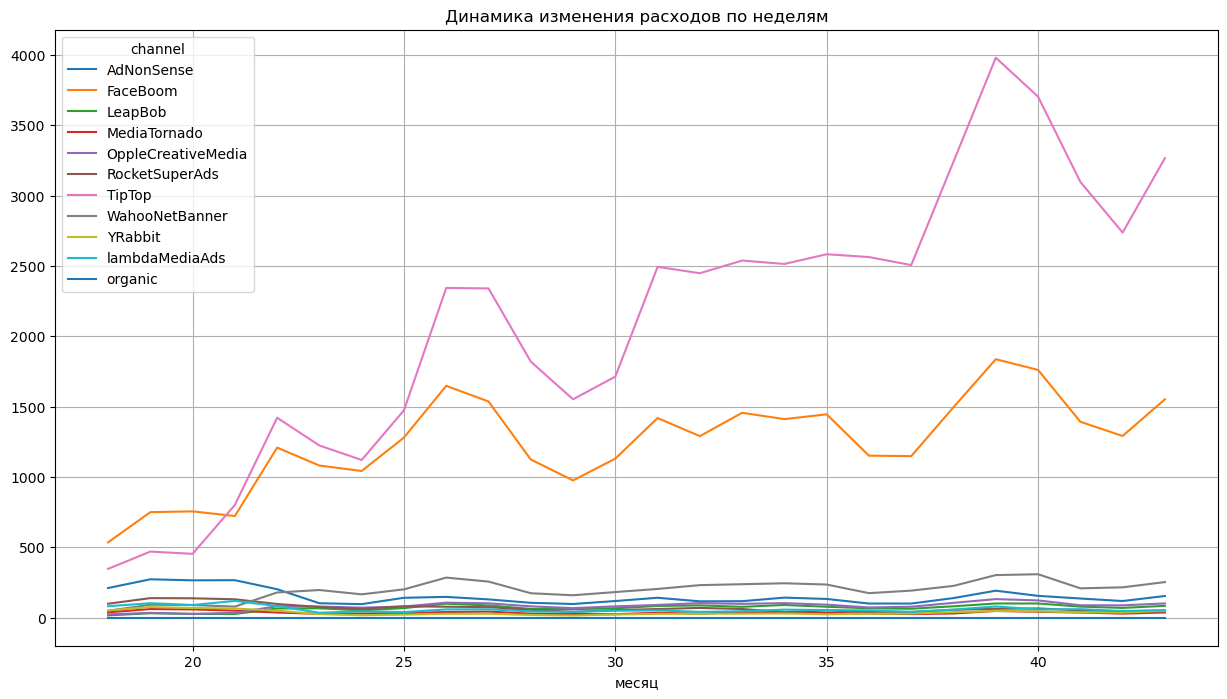

In [38]:
profiles.pivot_table(
    index='week', 
    columns='channel',  
    values='acquisition_cost',  
    aggfunc='sum'  
).plot(figsize=(15, 8), grid=True)
plt.title('Динамика изменения расходов по неделям')
plt.xlabel('месяц')
plt.show()

Сумма выделенная на рекламу в **TipTop** при этом в 1,5 раза выше, а пришедших пользователей в два раза меньше, значит, не проводилось ежемесячного отслеживания притока клиентов. При таких затратах на рекламу, каждый пользователь из **TipTop** обошелся в 2-3 раза дороже, чем из **FaceBoom**. Проверим это далее. 

#### Стоимость привлечения одного пользователя (CAC)

In [39]:
user_cost = profiles.pivot_table(index='channel', values='acquisition_cost', aggfunc=['count', 'sum'])
user_cost.columns = ['users', 'total_cost']
user_cost['per_user'] = user_cost['total_cost'] / user_cost['users'] 
user_cost.sort_values(by='per_user', ascending=False)

users  total_cost  per_user
channel                                        
TipTop              19561    54751.30  2.799003
FaceBoom            29144    32445.60  1.113286
AdNonSense           3880     3911.25  1.008054
lambdaMediaAds       2149     1557.60  0.724802
WahooNetBanner       8553     5151.00  0.602245
RocketSuperAds       4448     1833.00  0.412095
OppleCreativeMedia   8605     2151.25  0.250000
YRabbit              4312      944.22  0.218975
MediaTornado         4364      954.48  0.218717
LeapBob              8553     1797.60  0.210172
organic             56439        0.00  0.000000

Предположение подтвердилось - пользователи пришедшие из **TipTop** почти в 3 раза дороже, чем из **FaceBoom**. Также видим, что **AdNonSense** сравним по стоимости привлечения с **FaceBoom**. Остальные каналы дешевле. Самые дешевые каналы - **OppleCreativeMedia, YRabbit, MediaTornado и LeapBob** - принесли столько же пользователей, сколько каналы средней стоимости, они могут оказаться более выгодными для рекламы.  

Для заключительной оценки выгодности рекламных источников необходимо сопоставить затраты на каждого пользователя с прибылью, которую он в среднем приносит.

### Оценка окупаемости рекламы

Установим момент и горизонт анализа данных. Считаем, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее, чем через две недели после привлечения.

Канал organic (бесплатные пользователи) составляет целых 13% от всех платящих пользователей и входит в топ 3. Это существенная доля. Мы оцениваем окупаемость рекламы, а значит исключим пользователей из бесплатных источников, чтобы не искажать картину.

In [40]:
profiles_ad = profiles.query('channel != "organic"')

In [41]:
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14
observation_date

datetime.date(2019, 11, 1)

#### Анализ окупаемости рекламы

Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

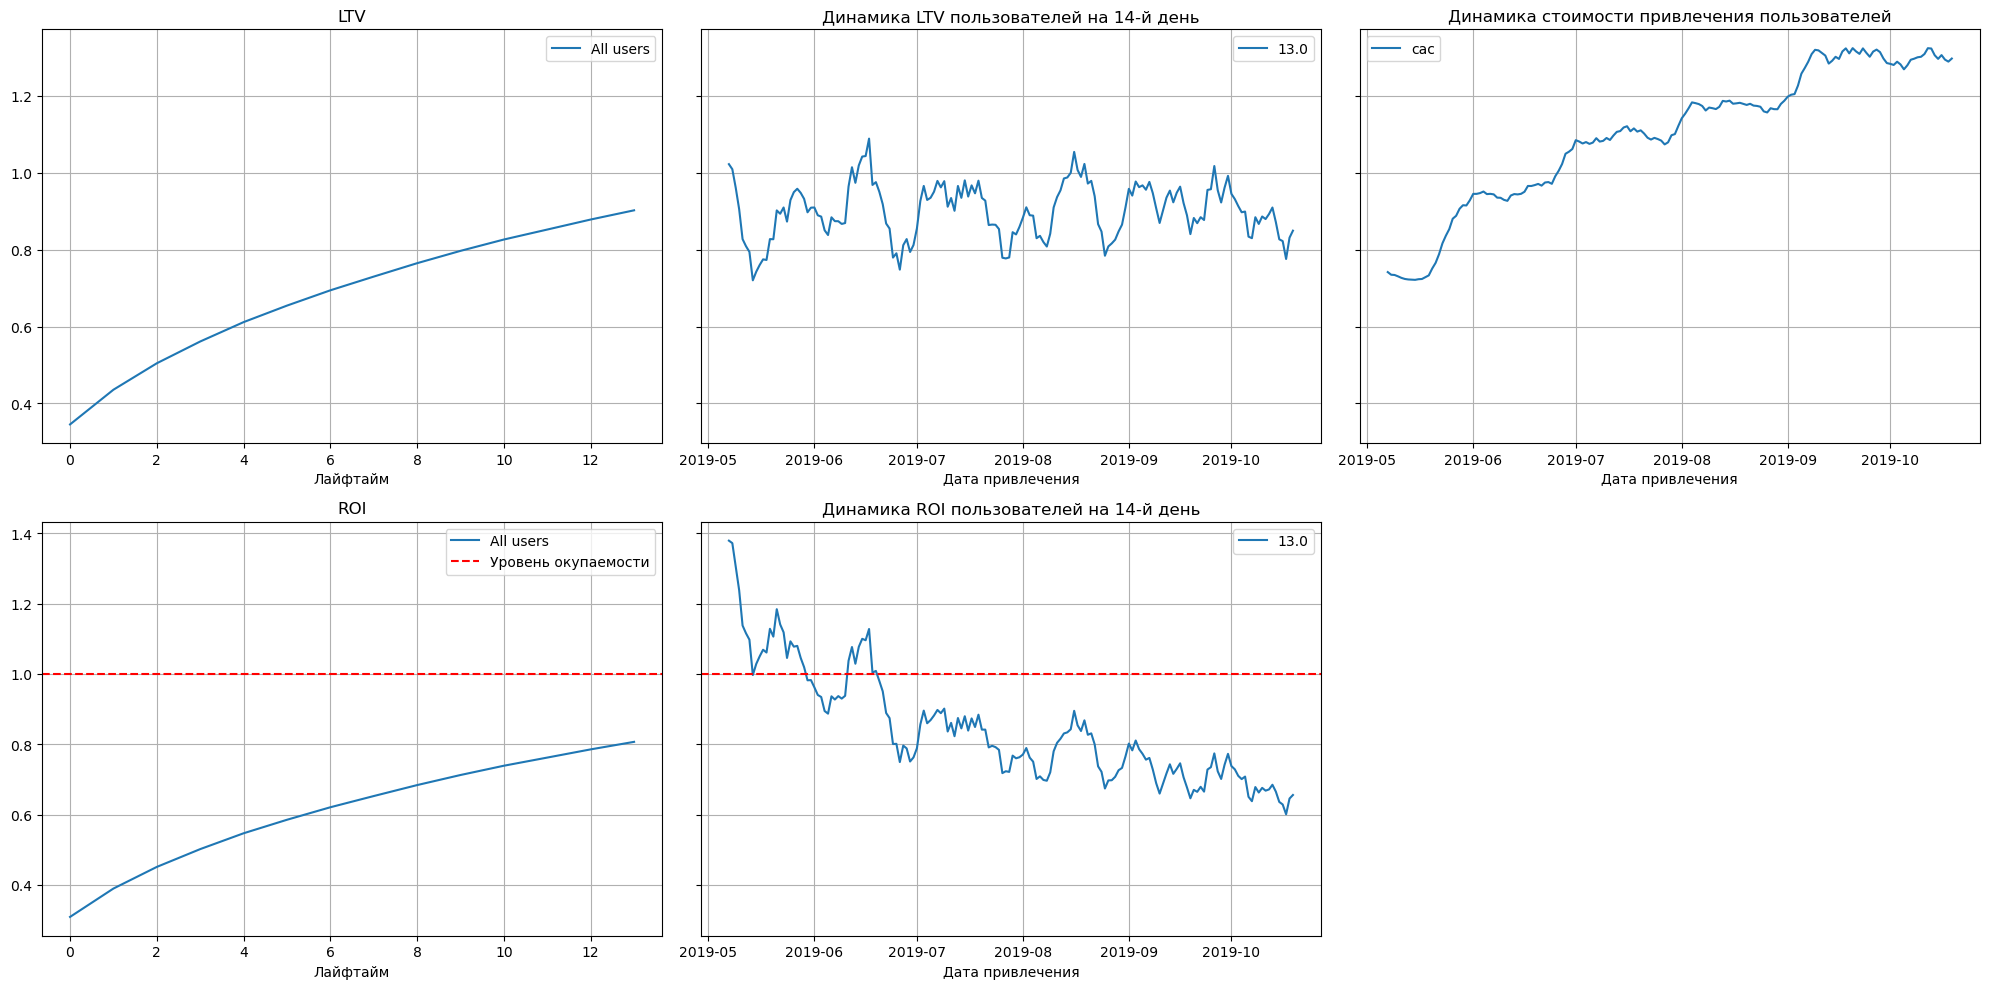

In [42]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_ad, orders, observation_date, horizon_days
)
# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

По графикам видно:
- Доход не покрывает затраты на рекламу - ROI к концу лайфтайма достигает только 80%.  
- Стоимость привлечения пользователей (CAC) сильно возростает к концу анализируемого периода. 
- При сравнении динамики LTV и ROI на 14 день видим, что LTV в среднем стабильно, а вот ROI закономерно падает и уже со второго месяца начинаются убытки. Значит, в среднем, доход с клиента не изменился, а затраты на рекламу увеличились.

Визуализируем детали - сделаем разбивку по странам, устройствам и рекламным источникам.

#### Разбивка по странам

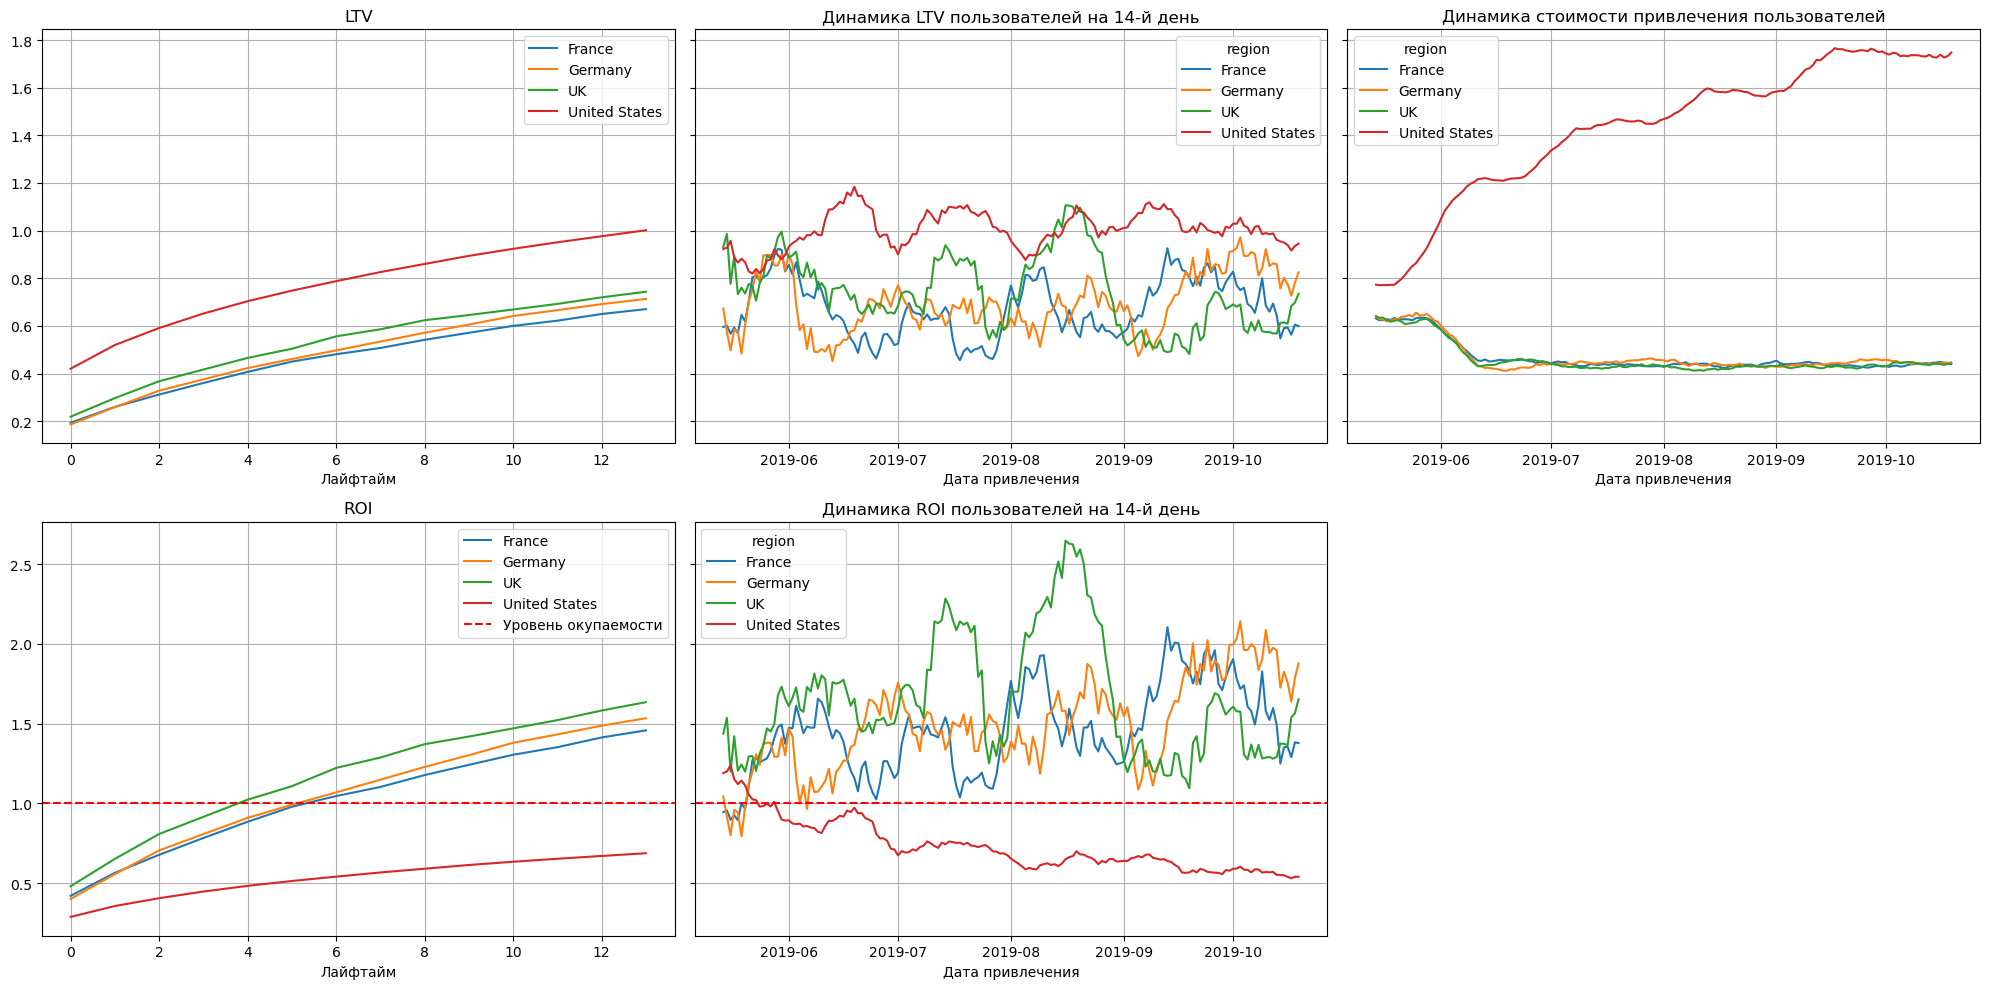

In [43]:
# смотрим окупаемость с разбивкой по странам
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_ad, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

По странам видно:
- Пользователи **США** приносят больше дохода, но при этом стоимость их привлечения в несколько раз выше, чем в остальных странах. На графике окупаемости (ROI) видно, что **США** - единственный регион, который не покрывает затрат на рекламу. Остальные страны окупаются.
- По графикам динамики LTV и ROI также видно, что LTV в среднем стабильно, а ROI у США падает на протяжении всего периода. ROI по остальным странам в среднем немного растет. В Великобритании самая переменчивая окупаемость по месяцам.
- Стоимость привлечения пользователей (CAC) возросла только в США. В остальных странах она наоборот упала со второго месяца и далее оставалась стабильной.  

Мы видим явную зависимость окупаемости от страны пользователя.

#### Разбивка по устройствам

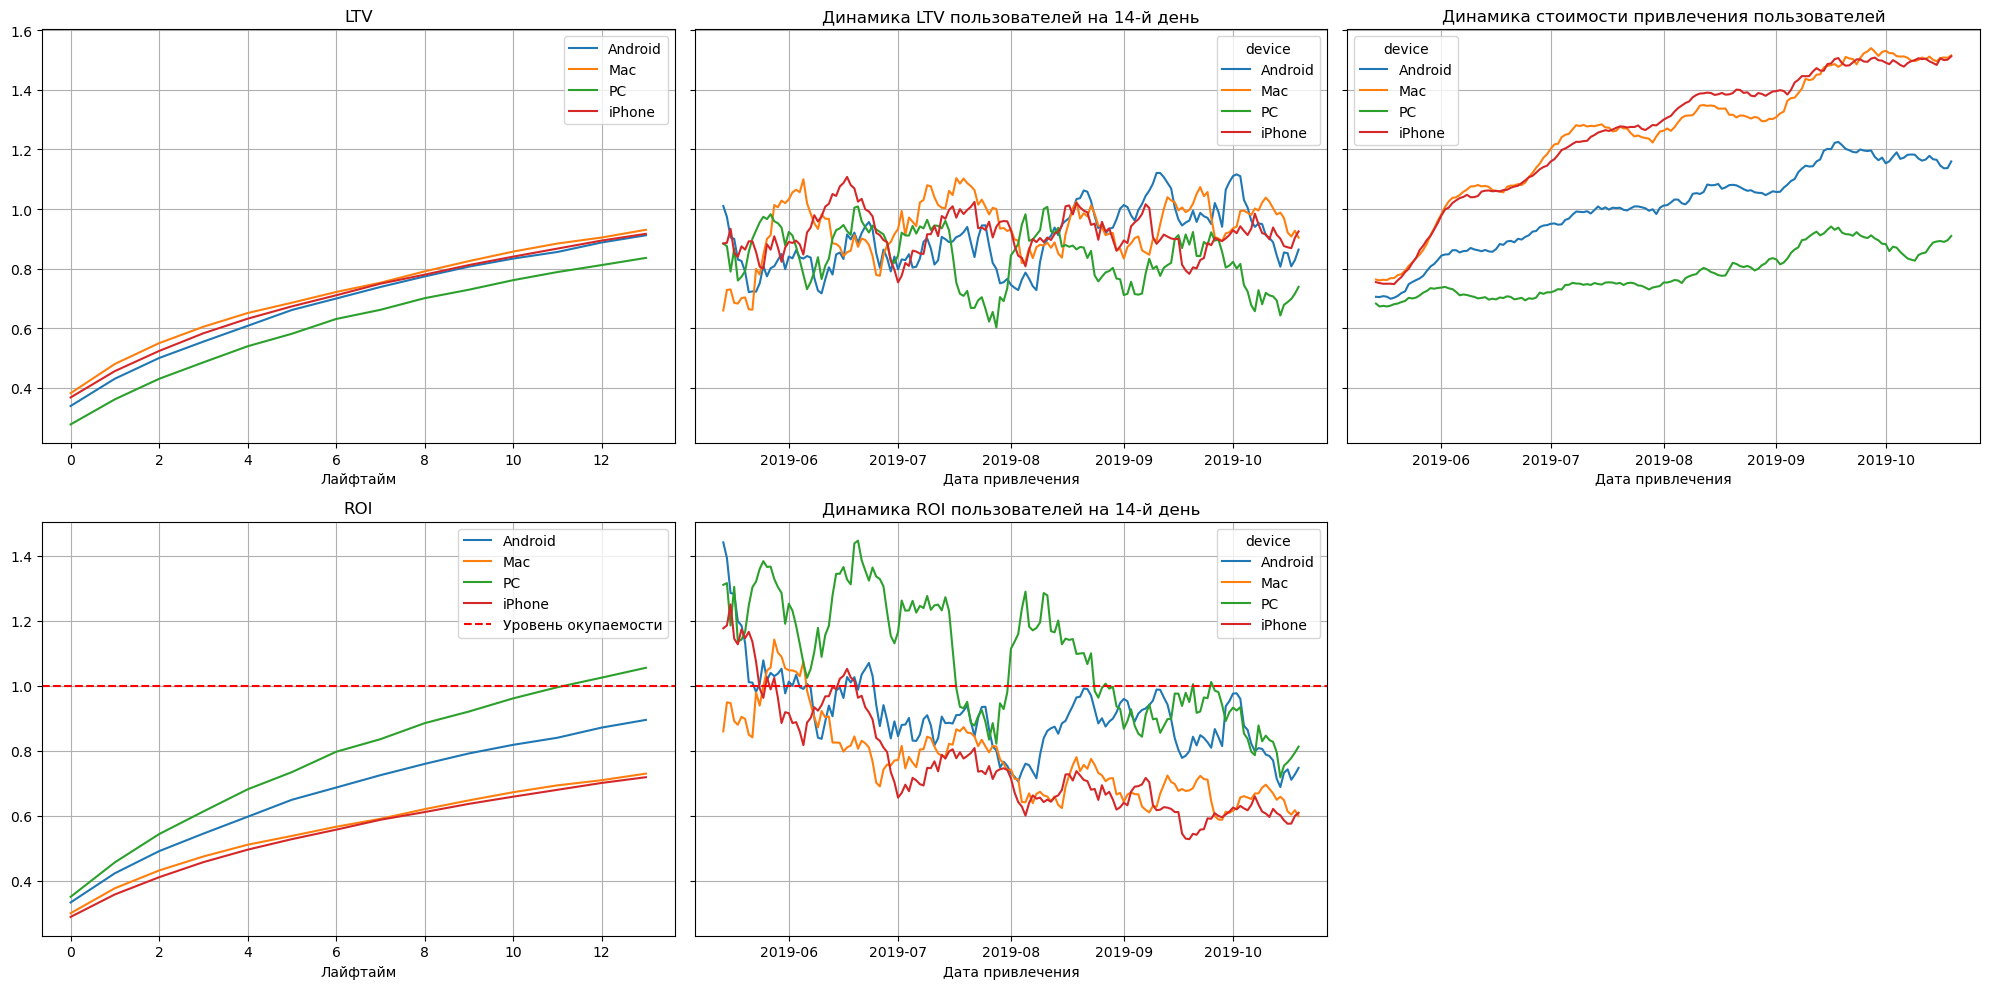

In [44]:
# смотрим окупаемость с разбивкой по устройствам
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_ad, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

По графиками устройств видно:
- Доход с пользователей на разных устройствах почти одинаковый. 
- Пользователи с PC единственные, кто окупаются.
- Динамика LTV стабильна, динамика ROI на всех устройствах падает. Также видим, что пользователи с PC окупались только в первые 4 месяца.
- Стоимость привлечения пользователей (CAC) со всех устройств росла на протяжении всего периода.
- Основная часть пользователей США используют технику Apple, на графиках ROI для iPhone и Mac наиболее низкий, на подъем этих показателей стоит обратить особое внимание.

Можем сделать вывод, что устройство входа не является существенной характеристикой, влияющей на прибыль, тем не менее окупаемость рекламы на устройствах **PC** выше, а стоимость привлечения ниже, чем на остальных. Рассмотрим отдельно их  рекламные каналы (5.6).

#### Разбивка по рекламным каналам

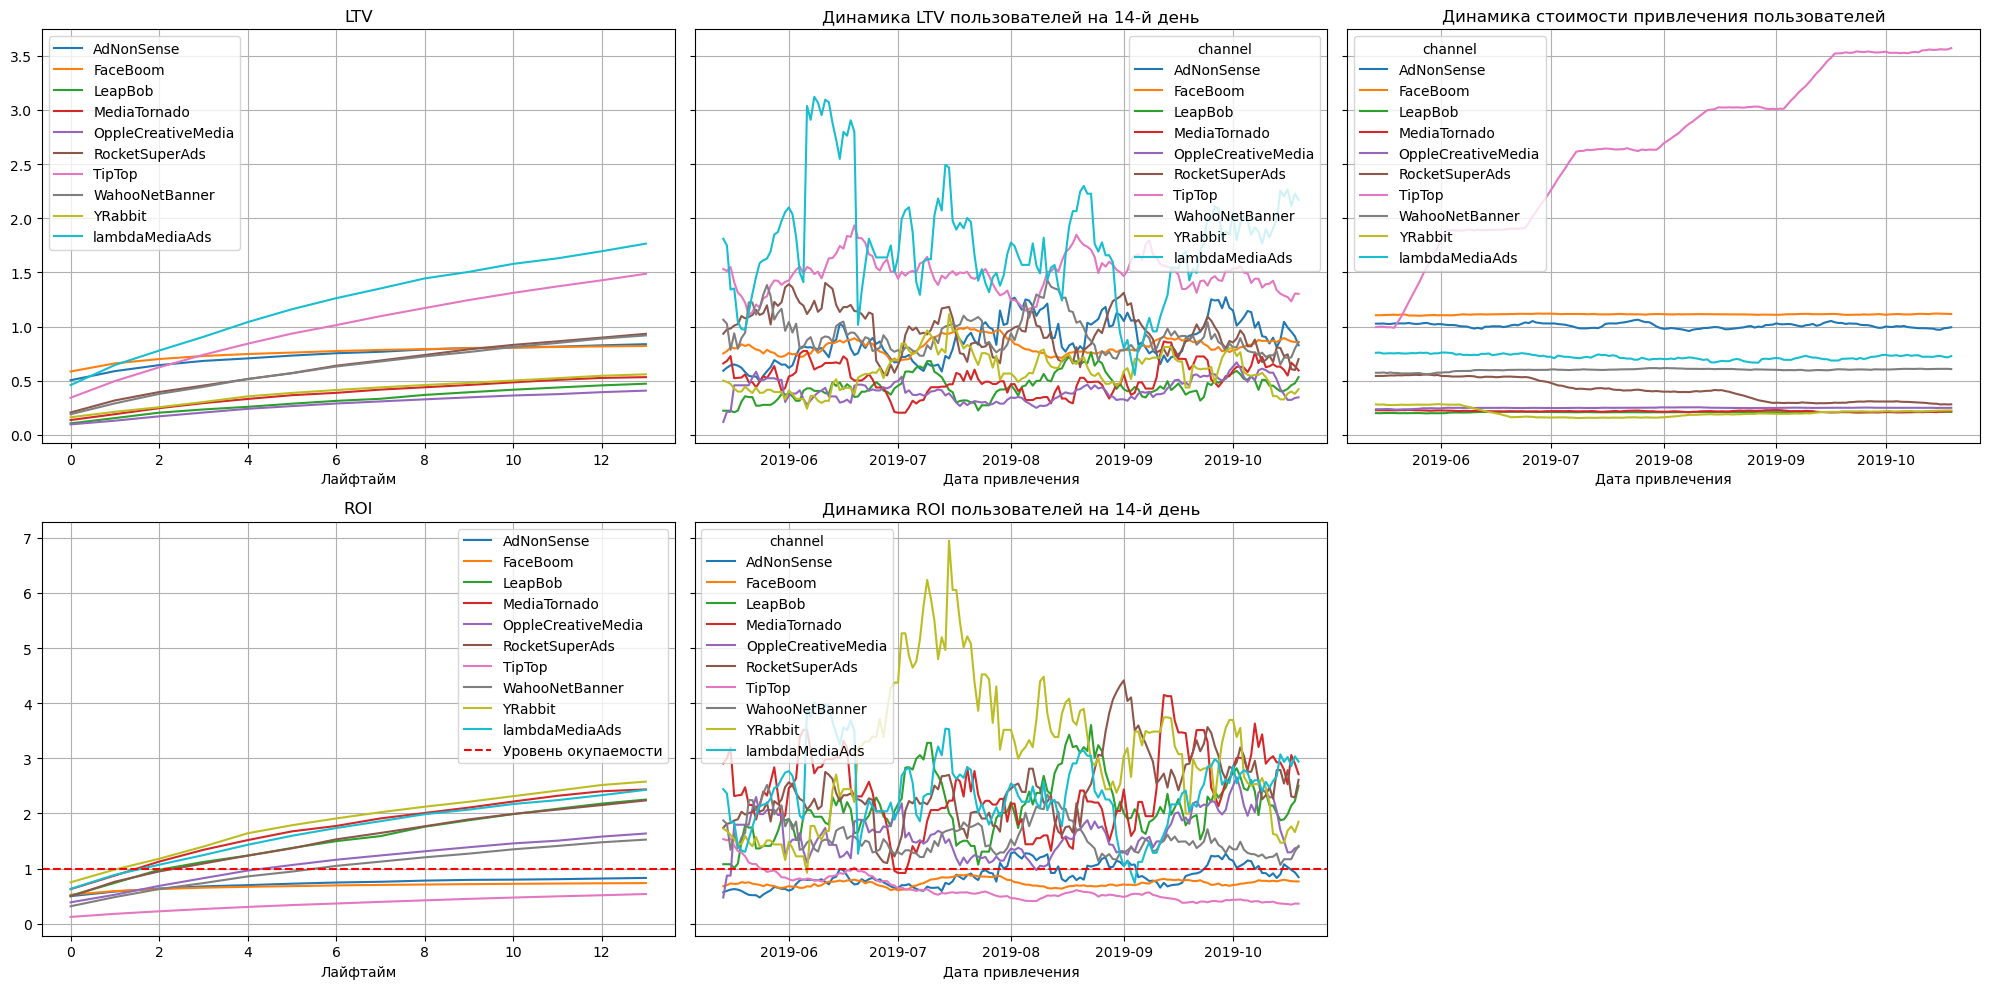

In [45]:
# смотрим окупаемость с разбивкой по рекламным каналам
dimensions = ['channel']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_ad, orders, observation_date, horizon_days, dimensions=dimensions
)
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Видим по графикам:
- Доход от пользователей, пришедших через каналы **lambdaMediaAds и TipTop** самый большой, при этом стоимость привлечения с первого канала окупается, а второй канал является самым убыточным - динамика стоимости привлечения на нем неприлично высокая и растет на протяжении всего периода. У остальных каналов динамика ровная.
- Помимо **TipTop** не окупается реклама на каналах **FaceBoom и AdNonSense**.
- Окупаемость каналов **YRabbit, MediaTornado, lambdaMediaAds** и **RocketSuperAds** - самая высокая.

Гипотезы из раздела 4.4 частично подтвердились.

Чтобы сделать выводы про каналы привлечения, посмотрим во всех ли странах они были одинаковыми:

In [46]:
ads_per_country = profiles.pivot_table(index='channel', columns='region', values='acquisition_cost', aggfunc='sum')
ads_per_country

region                   France      Germany           UK  United States
channel                                                                 
AdNonSense          1376.316788  1229.282545  1305.650668            NaN
FaceBoom                    NaN          NaN          NaN       32445.60
LeapBob              628.045578   529.946557   639.607864            NaN
MediaTornado                NaN          NaN          NaN         954.48
OppleCreativeMedia   747.336327   640.733464   763.180209            NaN
RocketSuperAds              NaN          NaN          NaN        1833.00
TipTop                      NaN          NaN          NaN       54751.30
WahooNetBanner      1789.137006  1552.972718  1808.890277            NaN
YRabbit                     NaN          NaN          NaN         944.22
lambdaMediaAds       535.138248   471.287952   551.173800            NaN
organic                0.000000     0.000000     0.000000           0.00

- **FaceBoom** и **TipTop** убыточные каналы для США, а **AdNonSense** - для стран Европы.
- **YRabbit, MediaTornado и RocketSuperAds** окупаемые каналы для США, а **lambdaMediaAds** - для стран Европы.  

Таким образом, каналы привлечения очень сильно влияют на окупаемость пользователей. Поскольку в США и Европе используются разные каналы рекламы, сейчас нельзя сделать однозначный вывод - дело в стране или в неправильно выбранном источнике. Продолжим анализ.

#### Разбивка по устройствам для США

Проверим два убыточных канала в США - TipTop и FaceBoom - со всех ли устройств пользователи не окупаются?

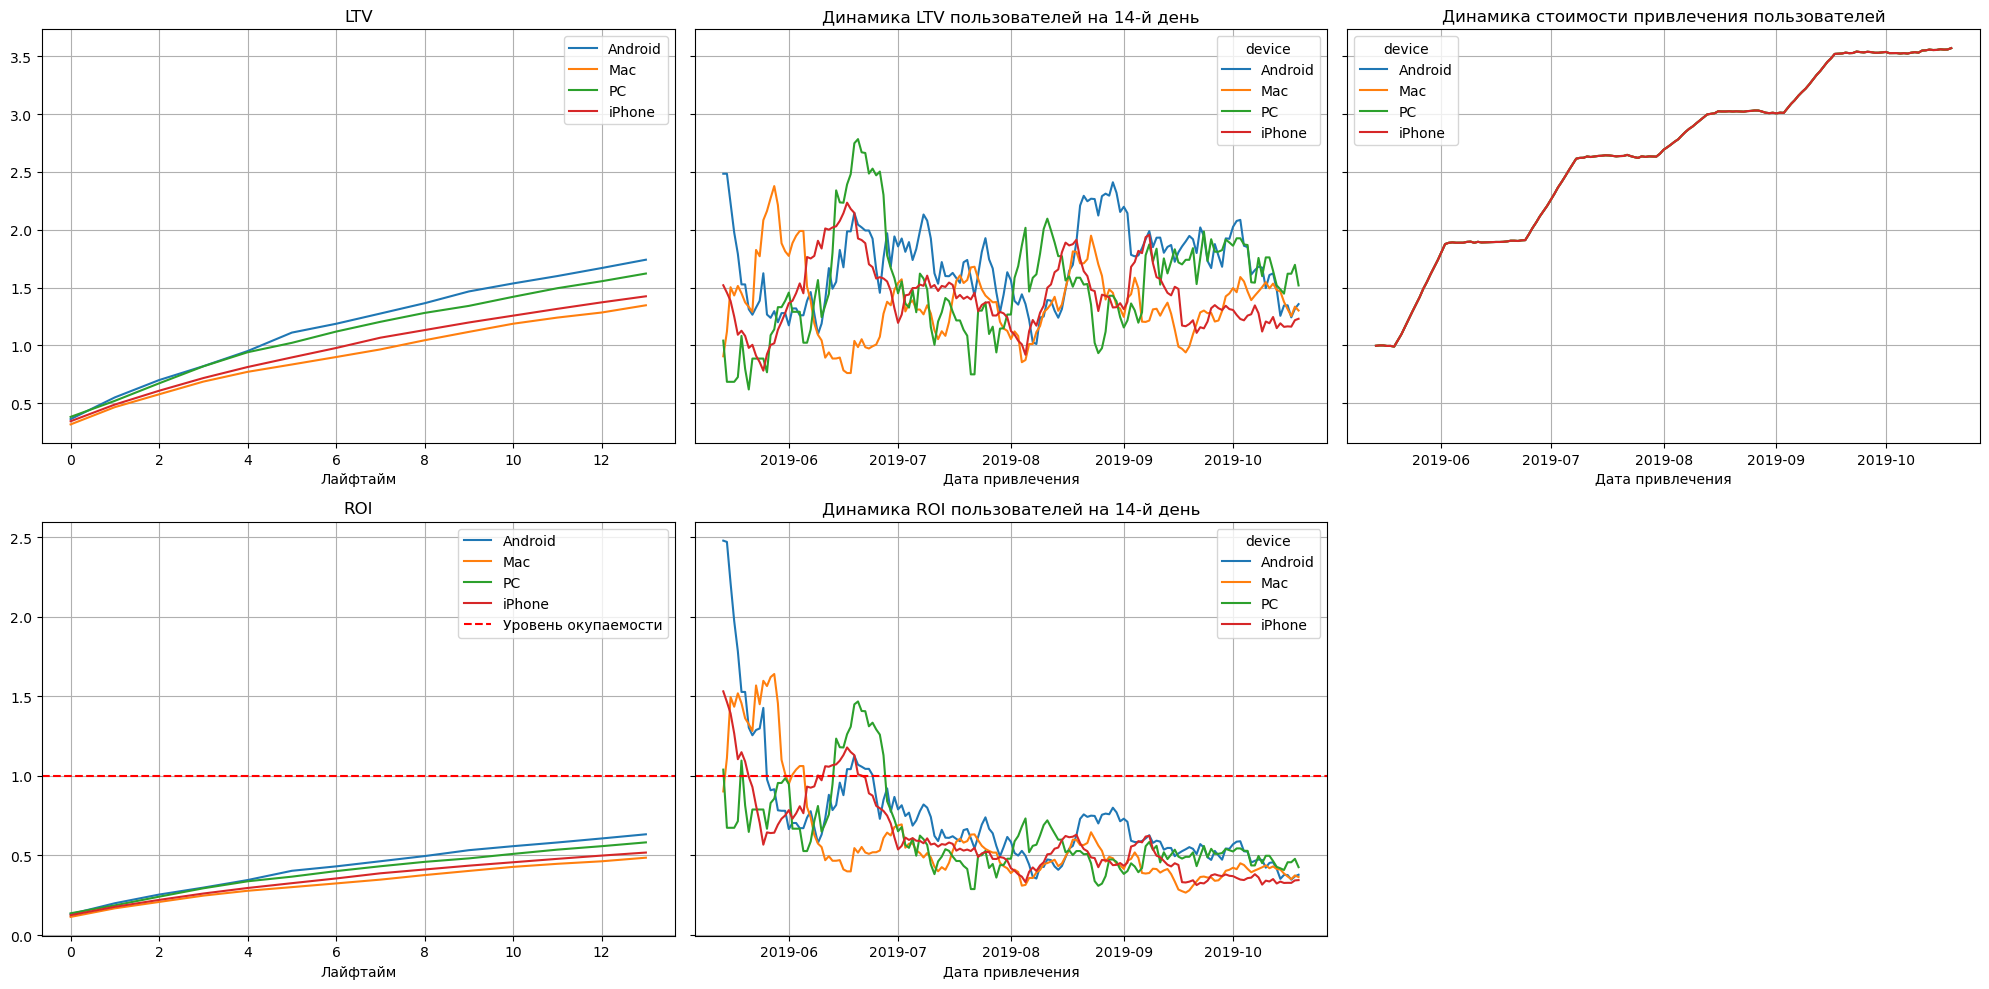

In [47]:
# смотрим окупаемость с разбивкой по устройствам для США
profiles_usa = profiles_ad.query('channel == "TipTop"')
dimensions = ['device']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_usa, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

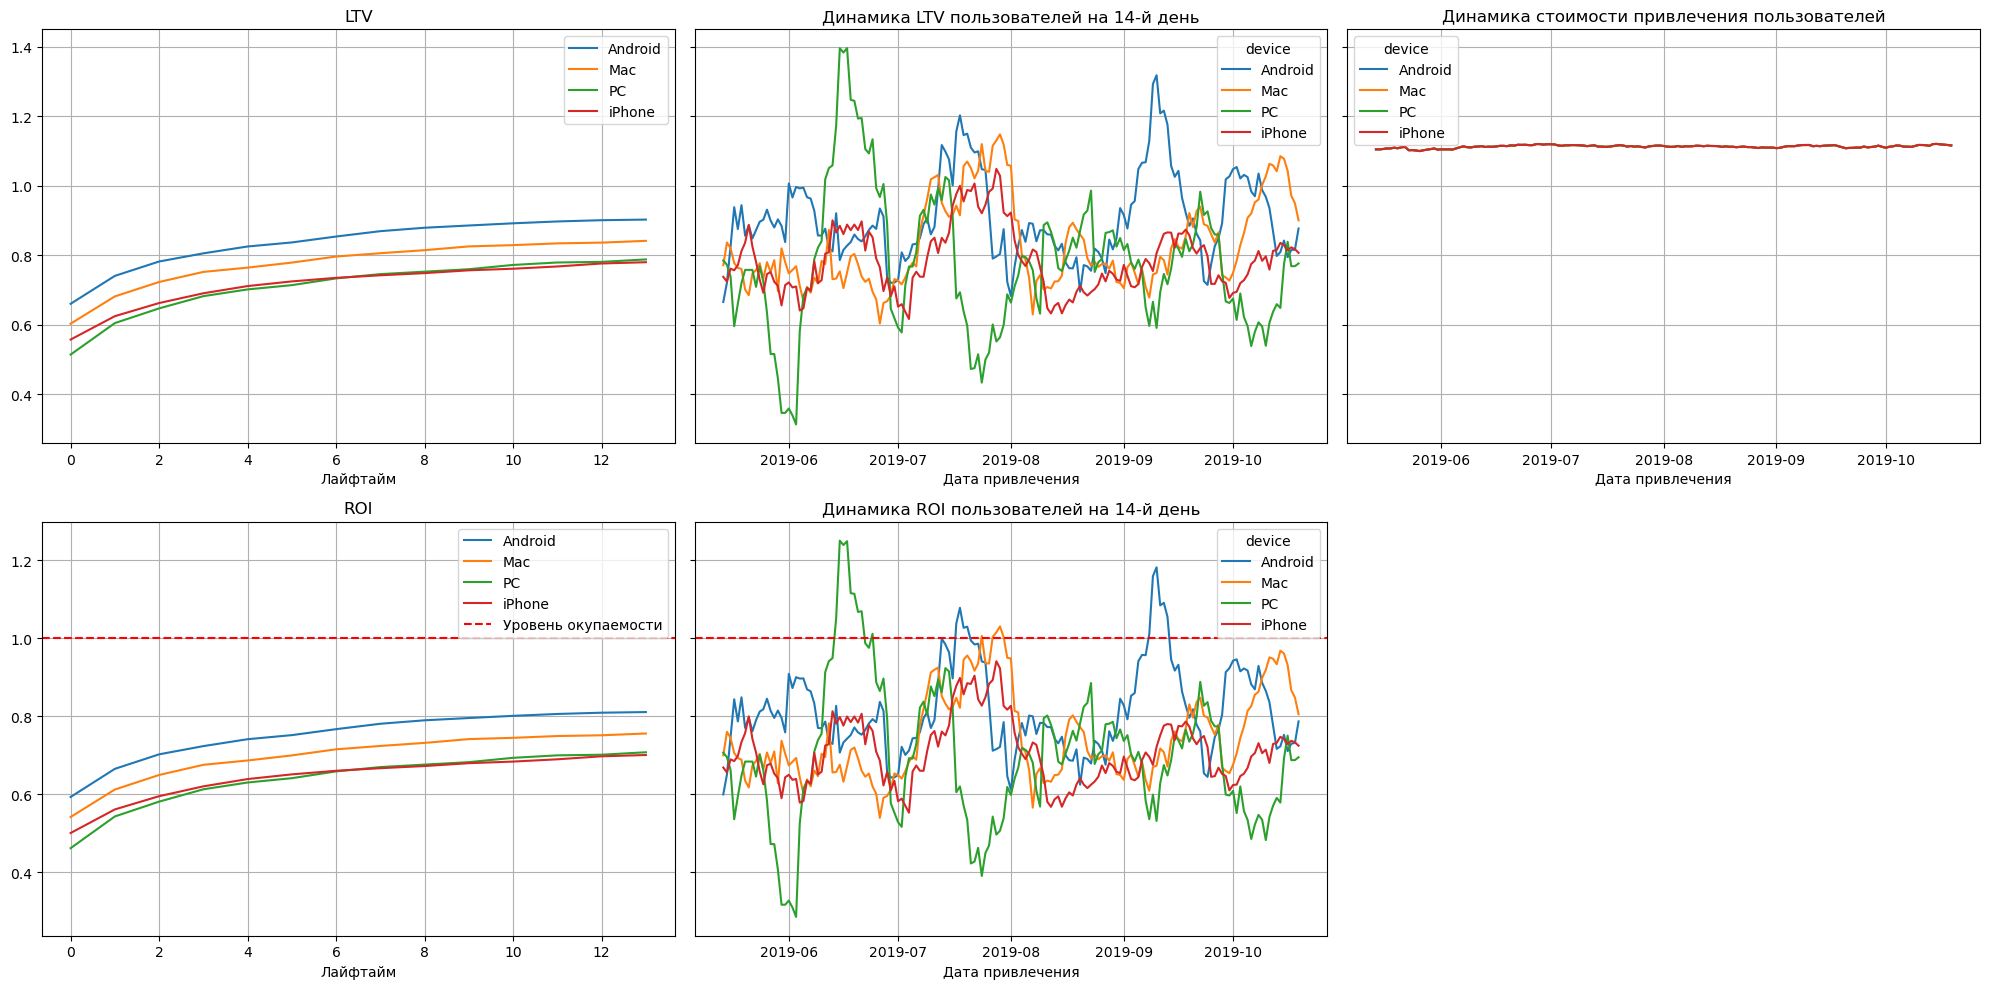

In [48]:
# смотрим окупаемость с разбивкой по устройствам для США
profiles_usa = profiles_ad.query('channel == "FaceBoom"')
dimensions = ['device']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_usa, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

В этих каналах для США нет никакого потенциала.

#### Разбивка по рекламным каналам для устройств PC

В разбивке по устройствам пользователи PC единственные показали окупаемость, а значит в них есть потенциал. Рассмотрим отдельно их рекламные каналы по странам:

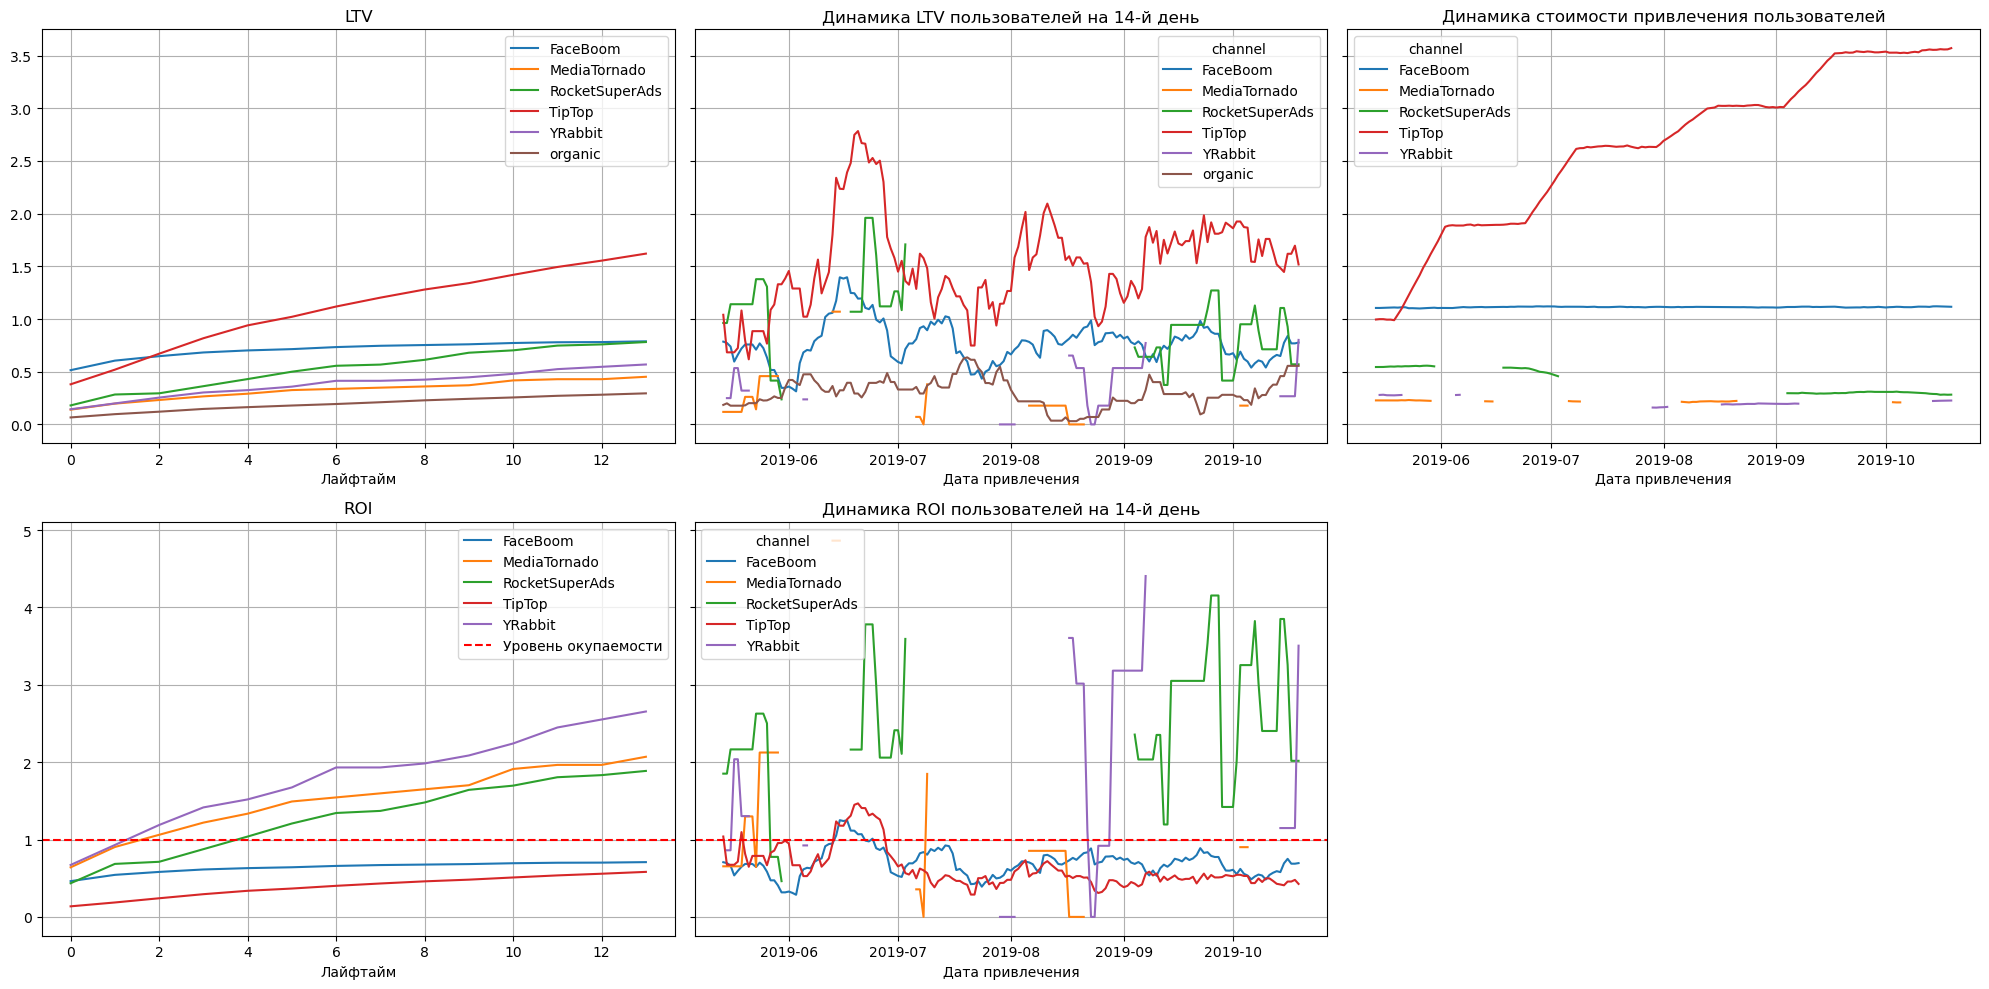

In [49]:
profiles_pc = profiles.query('device == "PC" & region == "United States"')
dimensions = ['channel']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_pc, orders, observation_date, horizon_days, dimensions=dimensions
)
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Окупаемые рекламные каналы для США - YRabbit, MediaTornado, RocketSuperAds

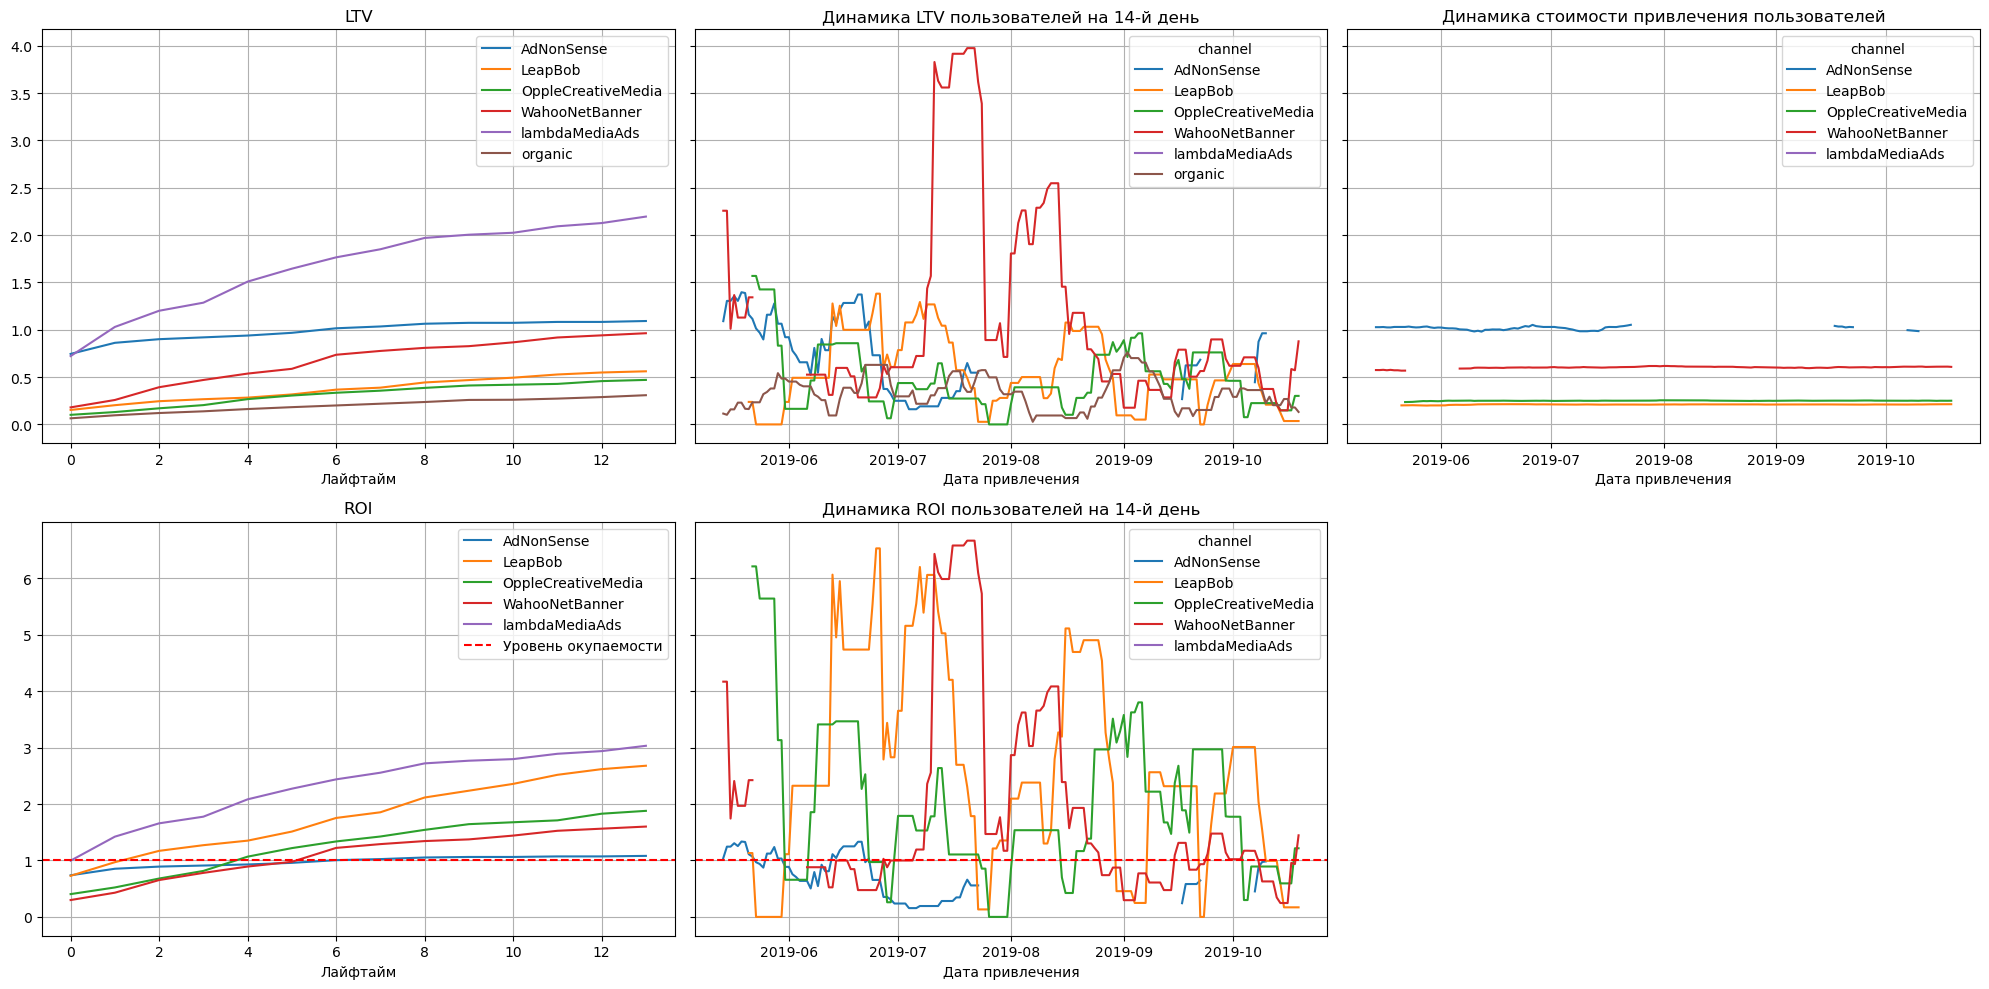

In [50]:
profiles_pc = profiles.query('device == "PC" & region == "UK"')
dimensions = ['channel']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_pc, orders, observation_date, horizon_days, dimensions=dimensions
)
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

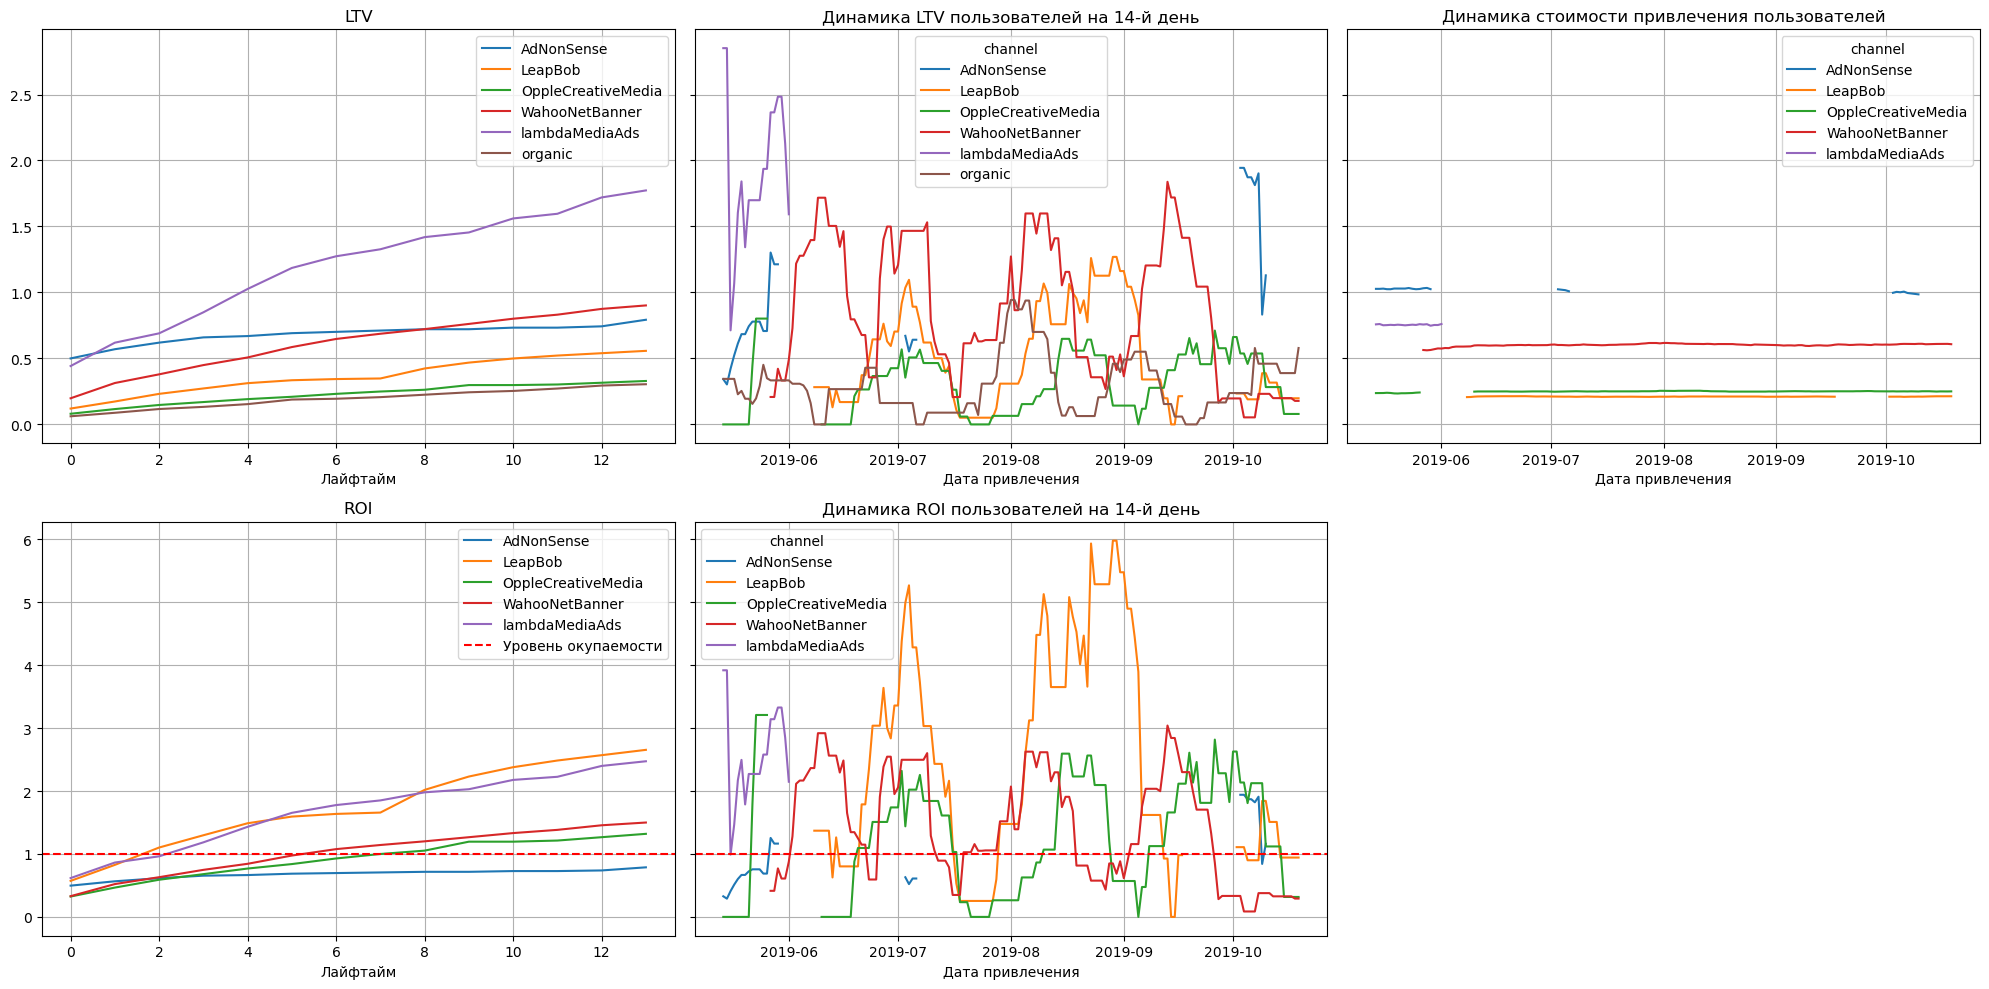

In [51]:
profiles_pc = profiles.query('device == "PC" & region == "France"')
dimensions = ['channel']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_pc, orders, observation_date, horizon_days, dimensions=dimensions
)
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

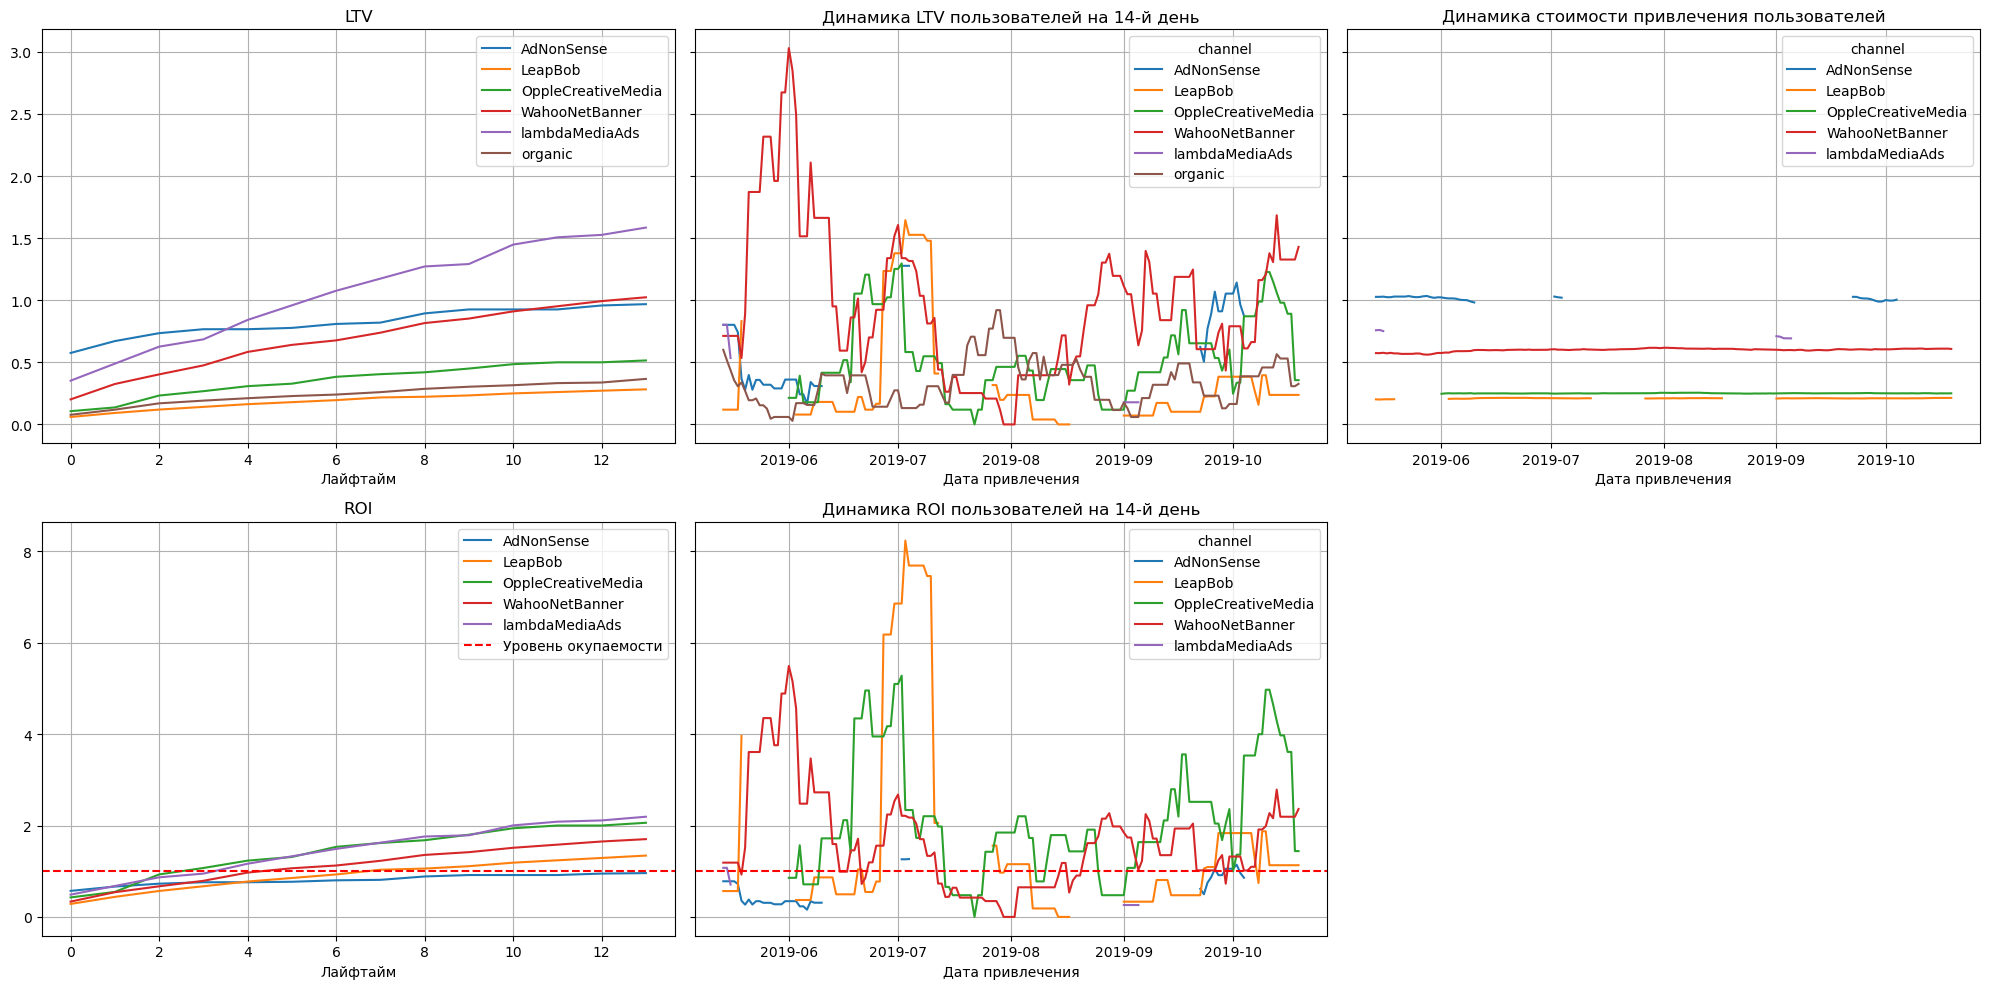

In [52]:
profiles_pc = profiles.query('device == "PC" & region == "Germany"')
dimensions = ['channel']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_pc, orders, observation_date, horizon_days, dimensions=dimensions
)
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Окупаемые рекламные источники для стран Европы - lambdaMediaAds, LeapBob, OppleCreativeMedia, WahooNetBanner.

#### Конверсия пользователей и динамика её изменения

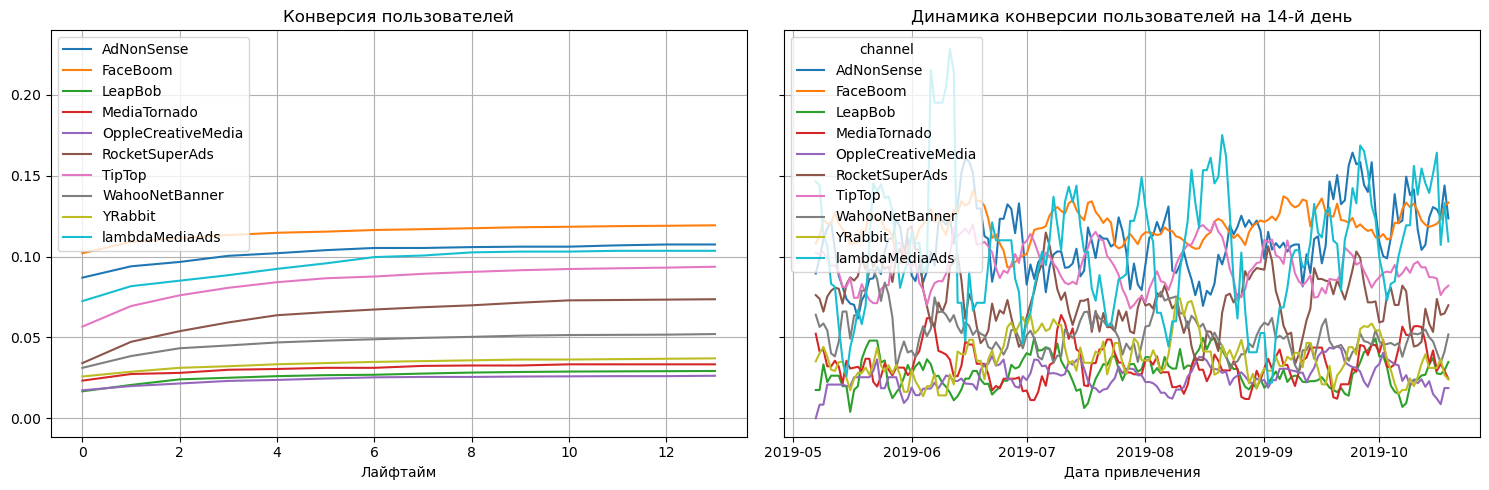

In [53]:
# смотрим конверсию с разбивкой по рекламным источникам 
dimensions = ['channel']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_ad, orders, observation_date, horizon_days, dimensions=dimensions
)
plot_conversion(conversion_grouped, conversion_history, horizon_days) 

По графикам видно, что пользователи конвертируются в основном в первые 4 дня жизни.  
Каналы **FaceBoom, AdNonSense, lambdaMediaAds и TipTop** - имеют хорошую конверсию 9-13%.

#### Удержание пользователей и динамика его изменения

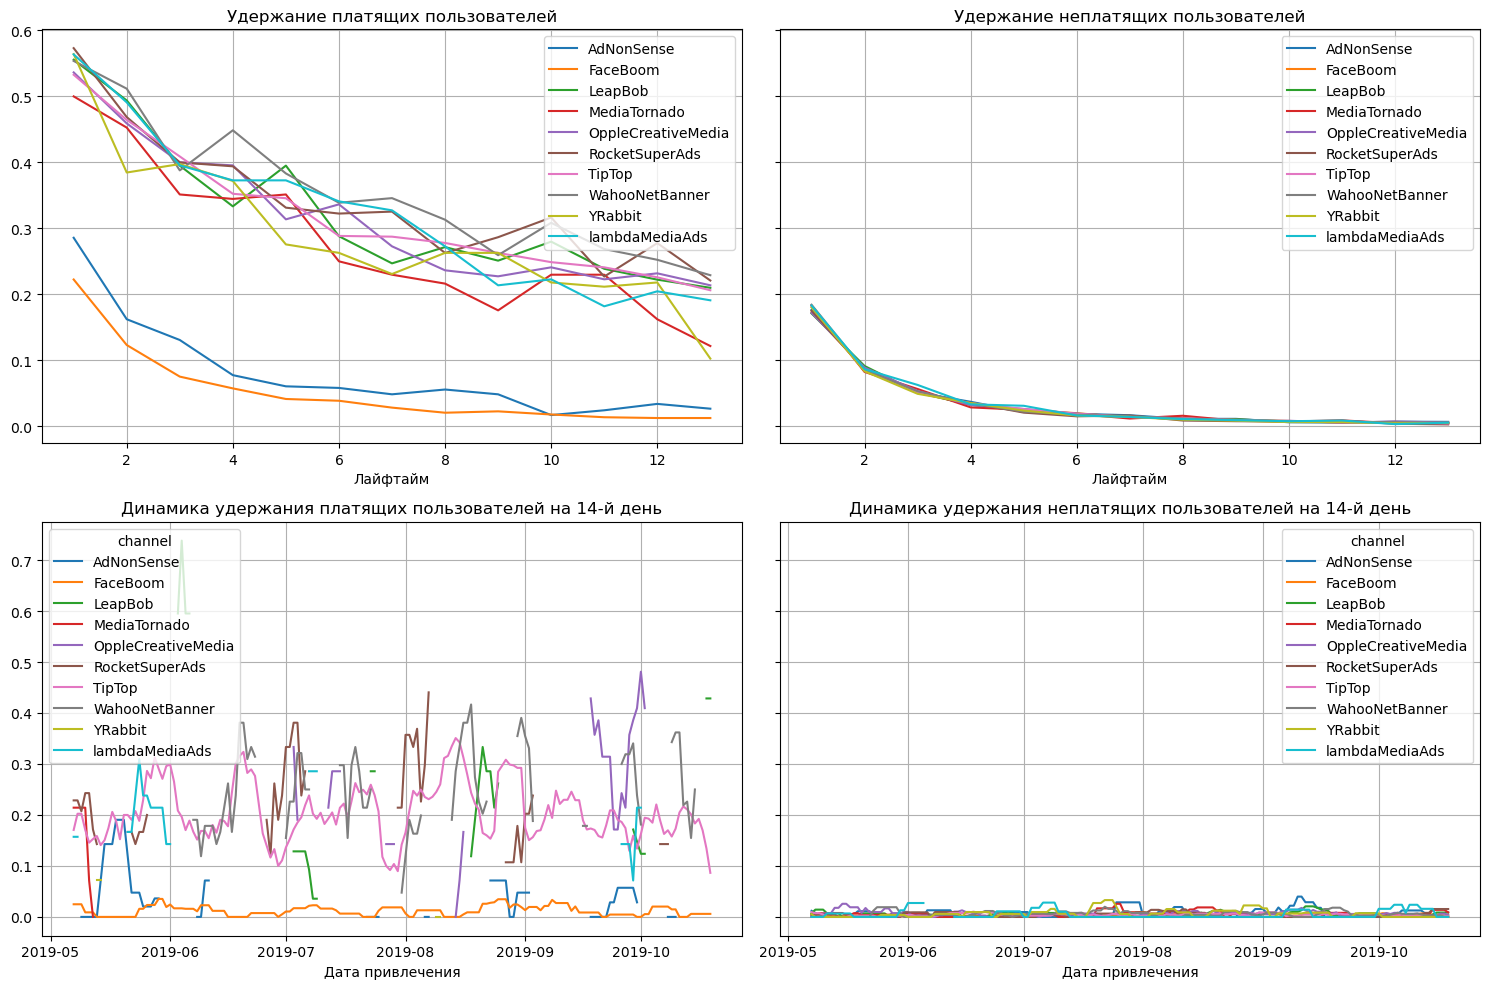

In [54]:
# смотрим удержание с разбивкой по рекламным источникам 
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_ad, visits, observation_date, horizon_days, dimensions=dimensions
)
plot_retention(retention_grouped, retention_history, horizon_days) 

Не смотря на хорошую конверсию, пользователи с каналов **FaceBoom** и **AdNonSense** очень плохо удерживаются (около 3% в конце лайфтайма), а стоимость их привлечения самая высокая!  
**TipTop** же удерживается как и остальные (около 20%), но не окупается, как мы видели в графике ROI, поскольку стоимость привлечения одного пользователя через него в несколько раз выше.

### Вывод

Мы проанализировали данные и поведение пользователей в приложении Procrastinate Pro+ по четырём регионам - США, Великобритания, Франция и Германия, в период с 1 мая по 1 ноября 2019 года. Создали профили пользователей с первой датой посещения сайта, каналом перехода, страной и девайсом. В профилях также присутствует отметка о совершении покупки и стоимости привлечения клиента.

**В ходе исследовательского анализа выяснилось:**
- Конверсия всех пользователей, зашедших в приложение - 6%
- Из них основную долю конверсии составляет **США - 78%**
- Доли платящих пользователей по остальным странам распределены одинаково
- Пользователи заходят в приложение с четырёх устройств: **iPhone, Mac, Android** и **PC**
- Больше всего платящих пользователей с устройств **iPhone - 38%**  
- Меньше всего пользователей с **PC - 17%**
- Больше всего платящих пользователей пришло из каналов **FaceBoom (40%), TipTop (21%) и Organic (13%)**. Остальные каналы сильно отстают.

**Оценка маркетинга:**
- Общая сумма расходов на маркетинг - 105497
- В несколько раз больше  денег потратили на рекламу в **TipTop** и **FaceBoom**. При этом с **TipTop** пришло в два раза меньше пользователей
- Расходы на рекламу в **TipTop** и **FaceBoom** с каждым месяцем растут. А расходы на другие источники не меняются
- Маркетологи применяли одинаковый подход к выделению бюджета на каналы **TipTop** и **FaceBoom**. Не проводилось ежемесячного отслеживания притока клиентов с этих каналов - сумма выделенная на рекламу в **TipTop** в 1,5 раза выше, чем на **FaceBoom**, а пришедших пользователей в два раза меньше. В итоге, пользователи пришедшие из **TipTop** обошлись в 3 раза дороже, чем из **FaceBoom**
- **AdNonSense** сравним по стоимости привлечения с **FaceBoom**. Остальные каналы существенно дешевле. 
- Самые дешевые каналы - **OppleCreativeMedia, YRabbit, MediaTornado и LeapBob** - принесли столько же пользователей, сколько каналы средней стоимости (они могут оказаться более выгодными для рекламы)
- Покупка рекламы совершается в начале и конце месяца


**Оценка окупаемости рекламы:**
- **Общий доход не покрывает затрат на рекламу - ROI к концу лайфтайма достигает только 80%.**  
- **Рекламные каналы являются главной характеристикой в оценке окупаемости**. Поскольку в США и Европе используются разные каналы рекламы, нельзя сделать однозначный вывод - дело только в каналах или ещё и в стране, для этого необходимы дополнительные исследования (например, купить рекламу в одинаковых источниках) 
- **FaceBoom и TipTop убыточные каналы для США, а AdNonSense - для стран Европы**. (FaceBoom, AdNonSense, lambdaMediaAds и TipTop - имеют хорошую конверсию 9-13%, но FaceBoom и AdNonSense очень плохо удерживаются (около 3% в конце лайфтайма), а стоимость их привлечения самая высокая! TipTop же удерживается как и остальные (около 20%), но не окупается, как мы видели в графике ROI, поскольку стоимость привлечения одного пользователя через него в несколько раз выше).
- **YRabbit, MediaTornado и RocketSuperAds окупаемые каналы для США, а lambdaMediaAds, OppleCreativeMedia и WahooNetBanner - для стран Европы**.  
- Устройство входа не является существенной характеристикой, влияющей на прибыль - доход с пользователей на разных устройствах почти одинаковый. Тем не менее, окупаемость у **PC** выше.
- Пользователи конвертируются в основном в первые 4 дня жизни. 

**РЕКОМЕНДАЦИИ ДЛЯ МАРКЕТОЛОГОВ:**
- **Исключить FaceBoom и TipTop из рекламных каналов пользователей США.** Подобрать новые каналы, оставить окупаемые YRabbit, MediaTornado и RocketSuperAds. 
- **Повысить удержание для пользователей из США** с помощью введения персонализированных UX-стратегий, e-mail рассылок, персональных рекомендаций, push-уведомлений. Ввести "награды" или привилегии для постоянных пользователей. Для канала FaceBoom настроить более таргетированное привлечение, направленное на пользователей с необходимыми характеристиками. Ввести поощрение пользователей за репосты контента и прочий социальный engagement, связанный с приложением, в данном канале.
- **Исключить неокупаемый канал AdNonSense для стран Европы** 
- Регулярно отслеживать приток платежных пользователей из различных каналов и оценивать их рентабельность (каждые 2 месяца)
- Обратить внимание на окупаемых пользователей **PC**, повысить рекламный бюджет в США для каналов - YRabbit, MediaTornado, RocketSuperAds, в странах Европы для - lambdaMediaAds, LeapBob, OppleCreativeMedia, WahooNetBanner.
- Необходимы дополнительные исследования, для оценки влияния страны на окупаемость клиентов.